In [102]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import numpy as np
import re

from PIL import Image
import spacy
from pymystem3 import Mystem
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, KMeans
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn

import string
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# DOwnloads

In [103]:
arr = os.listdir('../input/')
arr_df = pd.DataFrame(arr, columns = ['file_name'])
arr_df

,file_name
0,14773455.jl
1,file_7321705_455951711_124.jl
2,file_11834040_455951711_112.jl
3,w2.jl
4,file_10094987_455951711_145.jl
5,file_7233646_1133395834_1558.jl
6,.DS_Store
7,w3.jl
8,17597852.jl
9,5044562.jl


In [104]:
file_index = 33
path = f'../input/{arr_df["file_name"][file_index]}'

In [105]:
columns = ['comment', 'date_time', 'color','size', 'thumb_up', 'thumb_down', 'prod_eval', 'prod', 'brand']

df = pd.read_json(path).transpose().reset_index().drop('index', axis=1)
df = df.set_axis(columns, axis = 'columns')
print(df.shape)
df.head(5)

(976, 9)


,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,"Конверт для выписки вместо худи, серьезно?! Ну...",2021-04-28T16:57:13Z,"мятный, бледно-голубой",40-54,3,1,1,Худи длинное,People In
1,"Идеальное качество, не нашла ни одного косяка,...",2021-04-28T14:20:57Z,черный,40-54,0,1,5,Худи длинное,People In
2,Это просто самое бомбовое худи которое только ...,2021-04-28T11:26:04Z,"лавандовый, тускло-сиреневый",40-54,1,0,5,Худи длинное,People In
3,"Очень понравилось худи )Все качественно сшито,...",2021-04-27T12:21:00Z,"терракотовый, кирпично-красный",40-54,5,0,5,Худи длинное,People In
4,"худи действительно огромное, но с таким расчёт...",2021-04-26T16:11:18Z,"аквамариновый, бирюзовый",40-54,1,0,5,Худи длинное,People In


# Функции: Clean_text, Stopwords_del

In [106]:
def delete_non_letters(words):
    new_words = []
    words = words.split()
    
    for word in words:
        new_word = "".join(c if c.isalpha() else " " for c in word )
        
        if new_word != '':
            new_words.append(new_word)
    text = ' '.join(c for c in new_words)
        
    return text

In [107]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    

    #удаляет пунктуацию
    #translation_table = str.maketrans("", "", string.punctuation)
    #text = text.translate(translation_table)   
    
    text = text.lower()
    ## Clean the text
    text = re.sub(r"[,_»«\*!.\/'+-=)(]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\%", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\|", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r'"', " ", text)
    text = re.sub(r'«', " ", text)
    text = re.sub(r'\*', " ", text)
    text = re.sub(r'\?', " ", text)
    text = re.sub(r'»', " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    
    text = emoji_pattern.sub(r'', text)
    text = text.split()
    text = ' '.join(re.sub("[^А-Яа-яё]",'', i) for i in text)
    
    text = delete_non_letters(text)
    
    return text


In [108]:
def delete_stopwords(text): 
    text = text.split()
    text = [w for w in text if not w in russian_stopwords and len(w) >= 3]
    text = " ".join(text)
    
    return text

In [109]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,"Конверт для выписки вместо худи, серьезно?! Ну...",2021-04-28T16:57:13Z,"мятный, бледно-голубой",40-54,3,1,1,Худи длинное,People In
1,"Идеальное качество, не нашла ни одного косяка,...",2021-04-28T14:20:57Z,черный,40-54,0,1,5,Худи длинное,People In
2,Это просто самое бомбовое худи которое только ...,2021-04-28T11:26:04Z,"лавандовый, тускло-сиреневый",40-54,1,0,5,Худи длинное,People In
3,"Очень понравилось худи )Все качественно сшито,...",2021-04-27T12:21:00Z,"терракотовый, кирпично-красный",40-54,5,0,5,Худи длинное,People In
4,"худи действительно огромное, но с таким расчёт...",2021-04-26T16:11:18Z,"аквамариновый, бирюзовый",40-54,1,0,5,Худи длинное,People In


# Stopwords extension

In [110]:
file_name = 'StopWords_extension.csv'
path = f'../{file_name}'
SW = pd.read_csv(path, index_col = 'Index')
SW_list = SW['Word'].tolist()

In [111]:
prod_text = clean_text(df['prod'][0])
brand_text = clean_text(df['brand'][0])

In [163]:
stopwords_add_by_hand = ['фото','крутой','качественный','упаковка','норма', 'вещь','бомба','wildberries','ок', 'товар','брать','понравиться','качество','удобный','покупка', 'купить', 'цена','пломба','классный','доставка','очень','довольный', 'быстрый','быстро', 'хороший','отлично','все','прийти', 'класс','отличный', 'свой', 'отзыв', 'приходить', 'супер','это', 'спасибо', 'работа']
stopwords_add_by_category = [i for i in brand_text.split()]+[i for i in prod_text.split()]
stopwords_add_by_category

['худи', 'длинное']

In [164]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(stopwords_add_by_hand+stopwords_add_by_category+SW_list)

# Clean comments before lemmatization

In [165]:
%time
df['cleaned_comment'] = df['comment'].map(lambda x: clean_text(x))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 23.1 µs


In [166]:
df['cleaned_comment'] = df['cleaned_comment'].map(lambda x: delete_stopwords(x))

In [167]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment,lemma_comment_2
0,"Конверт для выписки вместо худи, серьезно?! Ну...",2021-04-28T16:57:13Z,"мятный, бледно-голубой",40-54,3,1,1,Худи длинное,People In,конверт выписки вместо серьезно какого фига,конверт выписка вместо серьезно фига,конверт выписка вместо серьезно фига
1,"Идеальное качество, не нашла ни одного косяка,...",2021-04-28T14:20:57Z,черный,40-54,0,1,5,Худи длинное,People In,идеальное нашла косяка привередливый покупател...,идеальный находить косяк привередливый покупат...,идеальный находить косяк привередливый рекомен...
2,Это просто самое бомбовое худи которое только ...,2021-04-28T11:26:04Z,"лавандовый, тускло-сиреневый",40-54,1,0,5,Худи длинное,People In,самое бомбовое которое цвет соответствует макс...,бомбовый цвет соответствовать максимально уютн...,соответствовать уютный мягкий шов идеальный ни...
3,"Очень понравилось худи )Все качественно сшито,...",2021-04-27T12:21:00Z,"терракотовый, кирпично-красный",40-54,5,0,5,Худи длинное,People In,понравилось качественно сшито приятный мягкий ...,качественно сшивать приятный мягкий материал т...,качественно сшивать приятный мягкий материал у...
4,"худи действительно огромное, но с таким расчёт...",2021-04-26T16:11:18Z,"аквамариновый, бирюзовый",40-54,1,0,5,Худи длинное,People In,огромное таким расчётом брала носить дома прох...,огромный расчет носить дома прохладный сезон у...,огромный носить дома прохладный уютный кокон л...


# Mystem lemmatization and drop empty comments

In [168]:
df.shape

(921, 12)

In [169]:
df = df.drop(df[df['cleaned_comment']==''].index).reset_index(drop = True)

In [170]:
def lemmatize(text): 
    text =  [i for i in text]
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    count = 0
    lemma = m.lemmatize(merged_text)
    for t in lemma:
        
        if '|' not in t and count+1<len(lemma):
            doc.append(t)
            count+=1
          
        else:
            doc = ''.join(i for i in doc)
            res.append(doc)
            count+=1
            doc = []
    return res

In [171]:
%time
res = lemmatize(df['cleaned_comment'])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [172]:
df['lemma_comment'] = res

# Delete StopWords

In [173]:
%time
df['lemma_comment'] = df['lemma_comment'].map(lambda x: delete_stopwords(x))
df = df.drop(df[df['lemma_comment']==''].index)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [174]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment,lemma_comment_2
0,"Конверт для выписки вместо худи, серьезно?! Ну...",2021-04-28T16:57:13Z,"мятный, бледно-голубой",40-54,3,1,1,Худи длинное,People In,конверт выписки вместо серьезно какого фига,конверт выписка вместо серьезно фига,конверт выписка вместо серьезно фига
1,"Идеальное качество, не нашла ни одного косяка,...",2021-04-28T14:20:57Z,черный,40-54,0,1,5,Худи длинное,People In,идеальное нашла косяка привередливый покупател...,идеальный находить косяк привередливый покупат...,идеальный находить косяк привередливый рекомен...
2,Это просто самое бомбовое худи которое только ...,2021-04-28T11:26:04Z,"лавандовый, тускло-сиреневый",40-54,1,0,5,Худи длинное,People In,самое бомбовое которое цвет соответствует макс...,бомбовый цвет соответствовать максимально уютн...,соответствовать уютный мягкий шов идеальный ни...
3,"Очень понравилось худи )Все качественно сшито,...",2021-04-27T12:21:00Z,"терракотовый, кирпично-красный",40-54,5,0,5,Худи длинное,People In,понравилось качественно сшито приятный мягкий ...,качественно сшивать приятный мягкий материал т...,качественно сшивать приятный мягкий материал у...
4,"худи действительно огромное, но с таким расчёт...",2021-04-26T16:11:18Z,"аквамариновый, бирюзовый",40-54,1,0,5,Худи длинное,People In,огромное таким расчётом брала носить дома прох...,огромный расчет носить дома прохладный сезон у...,огромный носить дома прохладный уютный кокон л...


In [175]:
df = df.reset_index(drop = True)

In [176]:
preprocessed_comments = df['lemma_comment']

# tf-idf

In [177]:
vectorizer = TfidfVectorizer(min_df=2)

In [178]:
vectorized_comments = vectorizer.fit_transform(preprocessed_comments)

In [179]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [180]:
#ф-ция определяет часть речи
def pos_define(x):
    m = Mystem()
    w = m.analyze(x)[0]
    pos = w['analysis'][0]['gr'].split(',')[0]
    pos = pos.split('=')[0].strip()
    return pos

# TFIDF1 result

In [181]:
tfidf = tfidf.sort_values(by=['tfidf'], ascending=True)

def final_topics(df):
    final_topics = []
    for x in df.index:
        if len(final_topics)<5:
            if pos_define(x) not in ['V','ADV']:
                final_topics.append(x)
        else: break
    return final_topics

tfidf1_res = pd.DataFrame(final_topics(tfidf), columns = ['tfidf'])
tfidf1_res

,tfidf
0,цвет
1,теплый
2,рост
3,размер
4,мягкий


# Spacy. Looking for most similar comments for each word

In [182]:
nlp = spacy.load('ru_core_news_lg')

In [183]:
def top_10_similar(word_for_checking, dataframe):

    critical_similarity_value = 0.47
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    pos = []
    for i in range(len(dataframe['lemma_comment'])):
        similarities.append(nlp(dataframe['lemma_comment'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    #сортировка по убыванию similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [184]:
top_10_similar('полагать', df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if __name__ == '__main__':


'По вашему запросу совпадений не найдено'

# Delete Stopwords. TFIDF once again

(array([  2.,   2.,   6.,  10.,  26.,  38.,  65., 115., 170., 406.]),
 array([2.02940229, 2.49914683, 2.96889138, 3.43863592, 3.90838047,
        4.37812502, 4.84786956, 5.31761411, 5.78735866, 6.2571032 ,
        6.72684775]),
 <BarContainer object of 10 artists>)

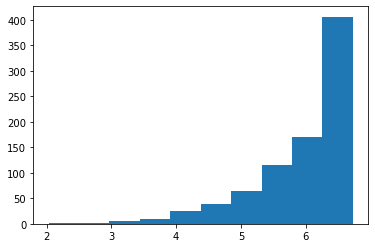

In [185]:
# df[~(df.gender == 'F') | (df.age > 40)]
plt.hist(tfidf.sort_values('tfidf')['tfidf'])

In [186]:
max_lim = 6
min_lim = 3

In [187]:
SW_tfidf = tfidf[(tfidf['tfidf']>max_lim)|(tfidf['tfidf']<min_lim)].reset_index()['index'].tolist()

In [188]:
russian_stopwords.extend(SW_tfidf)

In [189]:
%time
df['lemma_comment_2'] = df['lemma_comment'].map(lambda x: delete_stopwords(x))
df = df.drop(df[df['lemma_comment_2']==''].index)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 16.7 µs


In [190]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment,lemma_comment_2
0,"Конверт для выписки вместо худи, серьезно?! Ну...",2021-04-28T16:57:13Z,"мятный, бледно-голубой",40-54,3,1,1,Худи длинное,People In,конверт выписки вместо серьезно какого фига,конверт выписка вместо серьезно фига,конверт выписка вместо серьезно фига
1,"Идеальное качество, не нашла ни одного косяка,...",2021-04-28T14:20:57Z,черный,40-54,0,1,5,Худи длинное,People In,идеальное нашла косяка привередливый покупател...,идеальный находить косяк привередливый покупат...,идеальный находить косяк привередливый рекомен...
2,Это просто самое бомбовое худи которое только ...,2021-04-28T11:26:04Z,"лавандовый, тускло-сиреневый",40-54,1,0,5,Худи длинное,People In,самое бомбовое которое цвет соответствует макс...,бомбовый цвет соответствовать максимально уютн...,соответствовать уютный шов идеальный нитка ниг...
3,"Очень понравилось худи )Все качественно сшито,...",2021-04-27T12:21:00Z,"терракотовый, кирпично-красный",40-54,5,0,5,Худи длинное,People In,понравилось качественно сшито приятный мягкий ...,качественно сшивать приятный мягкий материал т...,качественно сшивать приятный материал уютный р...
4,"худи действительно огромное, но с таким расчёт...",2021-04-26T16:11:18Z,"аквамариновый, бирюзовый",40-54,1,0,5,Худи длинное,People In,огромное таким расчётом брала носить дома прох...,огромный расчет носить дома прохладный сезон у...,огромный носить дома прохладный уютный кокон л...


In [191]:
df = df.reset_index(drop = True)

In [192]:
preprocessed_comments_2 = df['lemma_comment_2']

In [193]:
vectorizer2 = TfidfVectorizer(min_df=2)
vectorized_comments_2 = vectorizer2.fit_transform(preprocessed_comments_2)

In [194]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf2 = dict(zip(vectorizer2.get_feature_names(), vectorizer2.idf_))
tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf2), orient='index')
tfidf2.columns = ['tfidf']

# TFIDF2 result

In [195]:
tfidf2 = tfidf2.sort_values(by=['tfidf'], ascending=True)

tfidf2_res = pd.DataFrame(final_topics(tfidf2), columns = ['tfidf'])
tfidf2_res

,tfidf
0,стирка
1,оверсайз
2,фото
3,приятный
4,капюшон


# Spacy2. Looking for most similar comments for each word

In [196]:
nlp = spacy.load('ru_core_news_lg')

In [197]:
def top_10_similar2(word_for_checking, dataframe):
    critical_similarity_value = 0.47
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    for i in range(len(dataframe['lemma_comment_2'])):
        similarities.append(nlp(dataframe['lemma_comment_2'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    
    #сортировка по убыванию similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [198]:
top_10_similar2('норма', df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  import sys


'По вашему запросу совпадений не найдено'

# Cloud of words

In [200]:
mask = np.array(Image.open('../berry.jpg'))
def new_wordcloud(tf_idf_indexes):
    unique_string=(" ").join(tf_idf_indexes)
    wordcloud = WordCloud(background_color='white', 
                          mask=mask,
                          width = mask.shape[1], 
                          height = mask.shape[0],
                          contour_width=3,
                          contour_color='red').generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

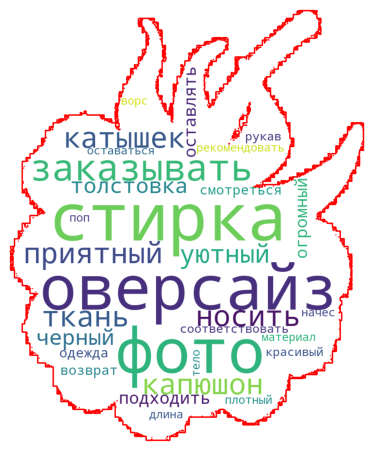

In [201]:
new_wordcloud(tfidf2.head(30).index)

# LDA

In [202]:
count_vect = CountVectorizer()
dataset_vectorized = count_vect.fit_transform(df['lemma_comment_2'])

In [203]:
lda = LDA(n_components = 15, max_iter=30, n_jobs=-1, learning_method='online', verbose=1, random_state=100, learning_decay = 0.65)
lda_output = lda.fit_transform(dataset_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [204]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(dataset_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(dataset_vectorized))

# See model parameters
print(lda.get_params())

Log Likelihood:  -45221.229146651276
Perplexity:  1017.5468351495265
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.65, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 30, 'mean_change_tol': 0.001, 'n_components': 15, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 1}


## Grid search LDA

In [205]:
# Define Search Param
search_params = {'n_components': [5, 9, 10], 'learning_decay': [.6, .9]}

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(dataset_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_it

iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_i

iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of ma

iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of ma

GridSearchCV(estimator=LatentDirichletAllocation(learning_decay=0.65,
                                                 learning_method='online',
                                                 max_iter=30, n_components=15,
                                                 n_jobs=-1, random_state=100,
                                                 verbose=1),
             param_grid={'learning_decay': [0.6, 0.9],
                         'n_components': [5, 9, 10]})

In [206]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dataset_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -11892.896738264519
Model Perplexity:  806.0011511488507


In [207]:
res = pd.DataFrame(model.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.748029,0.327661,0.055925,0.017919,0.6,5,"{'learning_decay': 0.6, 'n_components': 5}",-12366.302519,-11785.963734,-12587.666831,-12012.066690,-12000.753203,-12150.550596,287.109779,2
1,4.180523,0.238027,0.044912,0.006190,0.6,9,"{'learning_decay': 0.6, 'n_components': 9}",-13981.631824,-13099.153233,-13984.520173,-13338.620482,-13203.039394,-13521.393021,384.538109,5
2,4.362114,0.633574,0.051879,0.001748,0.6,10,"{'learning_decay': 0.6, 'n_components': 10}",-14659.171727,-13596.564279,-14528.300615,-13790.864692,-13694.206727,-14053.821608,447.019589,6
3,3.960949,0.119998,0.054005,0.003271,0.9,5,"{'learning_decay': 0.9, 'n_components': 5}",-12165.660805,-11691.089445,-12269.592334,-11680.173443,-11657.967665,-11892.896738,267.383194,1
4,4.047313,0.202125,0.051182,0.007571,0.9,9,"{'learning_decay': 0.9, 'n_components': 9}",-13450.712795,-12807.755164,-13482.659497,-12831.365196,-12709.767513,-13056.452033,337.579242,3


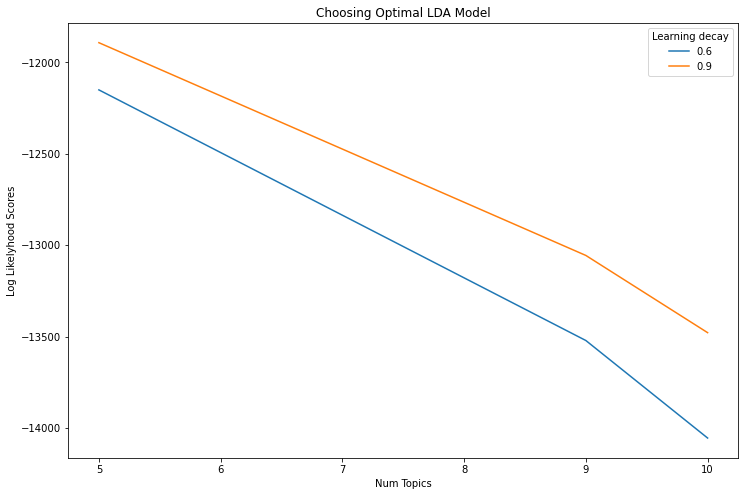

In [208]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 9, 10]
#log_likelyhoods_5 = res[res['param_learning_decay']==0.5][['mean_test_score']].round()
log_likelyhoods_6 = res[res['param_learning_decay']==0.6][['mean_test_score']].round()
log_likelyhoods_9 = res[res['param_learning_decay']==0.9][['mean_test_score']].round()

# Show graph
plt.figure(figsize=(12, 8))
#plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_6, label='0.6')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


## Topics LDA

In [209]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(dataset_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.030000,0.030000,0.030000,0.030000,0.870000,4
Doc1,0.860000,0.040000,0.030000,0.030000,0.030000,0
Doc2,0.010000,0.940000,0.010000,0.010000,0.010000,1
Doc3,0.010000,0.970000,0.010000,0.010000,0.010000,1
Doc4,0.020000,0.290000,0.640000,0.020000,0.020000,2
Doc5,0.040000,0.540000,0.330000,0.040000,0.040000,1
Doc6,0.020000,0.620000,0.020000,0.330000,0.020000,1
Doc7,0.020000,0.930000,0.020000,0.020000,0.020000,1
Doc8,0.600000,0.380000,0.000000,0.000000,0.000000,0
Doc9,0.030000,0.820000,0.030000,0.110000,0.030000,1


In [210]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,482
1,0,130
2,2,109
3,4,105
4,3,88


In [211]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, dataset_vectorized, count_vect, mds='tsne')
panel

/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  53.652917
0       51.163364 -159.968018       2        1  12.556621
2      -73.144554   21.523815       3        1  12.231926
4      -66.410133 -110.606438       4        1  11.797110
3       54.417324   12.443444       5        1   9.761426, topic_info=               Term       Freq      Total Category  logprob  loglift
1182      толстовка  51.000000  51.000000  Default  30.0000  30.0000
621        оверсайз  93.000000  93.000000  Default  29.0000  29.0000
989   рекомендовать  38.000000  38.000000  Default  28.0000  28.0000
1045         сильно  38.000000  38.000000  Default  27.0000  27.0000
780       подходить  42.000000  42.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
1048          синий   3.484228  12.622024   Topic5  -5.2092   1.0395
1262           фото   5.414309  93.555352   Topic5  -4.7684  -0.5228
780       подходить   4.203311  42.049548   Topic5  -5.0216   0.0238
1003          рукав   4.071214  43.730095   Topic5  -5.0535  -0.0474
579          носить   2.724610  56.230297   Topic5  -5.4551  -0.7004

[304 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         4  0.642983      абалденный
17        3  0.620030  безразмерность
18        1  0.382224         безумно
18        4  0.191112         безумно
18        5  0.382224         безумно
...     ...       ...             ...
1350      1  0.844899           яркий
1350      3  0.101388           яркий
1350      4  0.033796           яркий
1351      1  0.436890            ярко
1351      3  0.524269            ярко

[492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [212]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = count_vect.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,абалденный,абидный,аквамариновый,аккуратно,актуально,аорс,арлекино,архиудобный,ассоциация,байковый,...,энергозатратный,эстетика,эффект,юникать,являться,ягодный,ядреный,яркий,ярко,ярковатый
Topic0,0.205192,0.206779,0.207297,3.306314,0.207271,0.206697,0.206167,0.206836,0.207033,1.038464,...,0.206221,0.206472,0.207286,0.206405,0.206373,0.210714,0.206626,0.208732,0.213643,1.057366
Topic1,0.205866,1.093937,0.208194,5.928329,0.205829,1.094533,1.088814,0.408901,0.205268,0.205712,...,0.214278,1.074787,1.089809,1.093169,0.215159,1.079132,1.073031,28.582819,5.307598,0.251359
Topic2,0.206492,0.205451,0.206023,0.226982,0.204958,0.206255,0.207992,0.897592,0.207000,0.206356,...,0.206955,0.211101,0.206772,0.205847,1.094481,0.207021,0.205467,3.974099,7.342062,0.207926
Topic3,0.204834,0.206824,1.072133,0.207868,0.207344,0.208214,0.206118,0.205354,1.078536,0.206098,...,1.095428,0.207242,0.206853,0.206149,0.206699,0.206698,0.205747,0.240518,0.206569,0.205900
Topic4,1.094385,0.206622,0.205754,0.239355,1.072652,0.206645,0.207126,0.205212,0.207529,0.245336,...,0.206073,0.207192,0.205927,0.206372,0.207493,0.207009,0.206008,1.182375,0.227540,0.206915


# Top keywords LDA

In [213]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vect, lda_model = lda, n_words=1):
    keywords = np.array(count_vect.get_feature_names())
    topic_keywords = []
    final_topics = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()
        keywords_arr = keywords.take(top_keyword_locs)
        topic_keywords.append(keywords)
        
        for x in keywords_arr:
            
            if pos_define(x) not in ['V','ADV'] and x not in final_topics:
                final_topics.append(x)
                break
                
    return final_topics

final_topics = show_topics(vectorizer=vectorizer, lda_model = best_lda_model, n_words=1)        
final_topics
#Tfinal_topics Dataframe
df_final_topics = pd.DataFrame(final_topics, columns=['topic'])
df_final_topics

,topic
0,черный
1,стирка
2,огромный
3,толстовка
4,оверсайз


# GenSim